# EXPERIMENT USING DNN

In [717]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../data/sample_submission_ori.csv
../data/.DS_Store
../data/test.csv
../data/train.csv
../data/test.csv.zip
../data/train.csv.zip
../data/sample_submission.csv


In [718]:
def open_csv_as_dataframe(file_path:str) -> pd.DataFrame:
    """
    Opens a CSV file as a DataFrame.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pandas.DataFrame: The DataFrame containing the CSV data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print("Error: File not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [719]:
def summary_df(df:pd.DataFrame) -> pd.DataFrame:
    """
    Generates a summary of the DataFrame including data types, counts, unique values,
    percentages of unique values, null counts, percentages of null values, and basic 
    statistics for numeric columns.

    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.

    Returns:
    pd.DataFrame: Summary DataFrame.
    """
    df_copy = df.copy()
    
    # Initialize an empty DataFrame to store summary information
    desc = pd.DataFrame(index=list(df_copy))

    desc['type'] = df_copy.dtypes
    desc['count'] = df_copy.count()
    desc['nunique'] = df_copy.nunique()
    desc['%unique'] = desc['nunique'] / len(df_copy) * 100
    desc['null'] = df_copy.isnull().sum()
    desc['%null'] = desc['null'] / len(df_copy) * 100
    
    # Concatenate summary statistics for numeric columns
    desc = pd.concat([desc, df_copy.describe().T.drop('count', axis=1)], axis=1)
    desc = desc.sort_values(by=['type', 'null'])
    
    return desc

In [720]:
# Rename the columns for easier access
rename = {
         '02': 'Gender', '03': 'Date Of Birth',
         '04': 'Lead Creation Date','05': 'City Code',
         '06': 'Area Code','07': 'Employer Code',
         '08': 'Employer Category1','09': 'Employer Category2',
         '10': 'Monthly Income','11': 'Bank Code',
         '12': 'Bank Account Type','13': 'Marketing Source',
         '14': 'Marketing Category1','15': 'Marketing Category2',
         '16': 'Current Loan Installment','17': 'Requested Loan Amount',
         '18': 'Loan Repayment (Years)','19': 'Interest Rate',
         '20': 'Requested Loan Installment'
         }

In [721]:
# df_train = df_train.rename(columns=rename)
# df_test = df_test.rename(columns=rename)

In [722]:
# desc_train = summary_df(df_train)
# desc_train.style.background_gradient()

In [723]:
# create age column (age during loan application), for age invalid age(negative value), change the value to median
def create_age_column(df:pd.DataFrame) -> pd.DataFrame:
    """
    Creates a new column 'Age' from the 'Date Of Birth' and 'Lead Creation Date' columns.
    Change any age < 0 to median
    
    Parameters:
        df (DataFrame): Input DataFrame.
    
    Returns:
        DataFrame: DataFrame with age column.
    """
    df_copy = df.copy()
    
    df_copy['Date Of Birth'] = pd.to_datetime(df_copy['Date Of Birth'])
    df_copy['Lead Creation Date'] = pd.to_datetime(df_copy['Lead Creation Date'])
    df_copy['Age'] = (df_copy['Lead Creation Date'] - df_copy['Date Of Birth']).dt.days // 365

    # Calculate the mean of the 'age' column, excluding negative values
    # mean_age = df_copy[df_copy['Age'] >= 0]['Age'].mean()
    # df_copy.loc[df_copy['Age'] < 0, 'Age'] = mean_age
    # df_copy.loc[df_copy['Age'] < 0, 'Age'] = np.nan

    return df_copy

In [724]:
def create_debt_to_income_ratio_column(df:pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column indicating the debt to income ratio, adding a small value if the ratio is 0.
    
    Parameters:
        df (DataFrame): Input DataFrame containing 'Current Loan Installment' and 'Monthly Income' columns.
        small_value (float): Small value to add if the debt to income ratio is 0. Default is 1e-9.
    
    Returns:
        DataFrame: DataFrame with the new 'Debt To Income Ratio' column.
    """
    df_copy = df.copy()
    df_copy['Debt To Income Ratio'] = df_copy['Current Loan Installment'] / df_copy['Monthly Income']
    df_copy['Debt To Income Ratio'] = df_copy['Debt To Income Ratio'].apply(lambda x: x if x > 0 else 0)
    return df_copy

In [725]:
def create_monthly_loan_repayment_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column indicating the monthly loan repayment amount.
    
    Parameters:
        df (DataFrame): Input DataFrame containing 'Requested Loan Amount', 'Interest Rate', and 'Loan Repayment (Years)' columns.
    
    Returns:
        DataFrame: DataFrame with the new 'Monthly Loan Repayment' column.
    """
    df_copy = df.copy()
    
    # Calculate monthly interest rate
    df_copy['Monthly Interest Rate'] = df_copy['Interest Rate'] / 12 / 100
    
    # Convert years to total number of payments (months)
    df_copy['Total Repayments Month'] = df_copy['Loan Repayment Years'] * 12
    
    # Calculate the monthly loan repayment amount using the formula (EMI)
    numerator = df_copy['Requested Loan Amount'] * df_copy['Monthly Interest Rate'] * (1 + df_copy['Monthly Interest Rate'])**df_copy['Total Repayments Month']
    denominator = ((1 + df_copy['Monthly Interest Rate'])**df_copy['Total Repayments Month']) - 1
    df_copy['Monthly Loan Repayment Amount'] = numerator / denominator

    #drop unnessary columns
    df_copy = df_copy.drop(['Total Repayments Month', 'Monthly Interest Rate'], axis=1)

    return df_copy


In [726]:
def create_payment_to_income_ratio_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify if applicants have enough balance to pay for the applied loan.
    
    Parameters:
        df (DataFrame): Input DataFrame containing 'Monthly Income', 'Current Monthly Loan Installment', 
                        'Requested Loan Amount', 'Interest Rate', and 'Loan Repayment (Years)' columns.
    
    Returns:
        DataFrame: DataFrame with a new column 'Can Afford Loan' indicating whether applicants have enough balance to pay for the applied loan.
    """
    df_copy = df.copy()

    #Calculate Payment-to-income-ratio
    df_copy['Payment to Income Ratio'] = df_copy.apply(lambda row:
        (row['Monthly Loan Repayment Amount'] + row['Current Loan Installment']) / row['Monthly Income'] 
        if row['Monthly Income'] > 0 else 0,
        axis=1
    )

    return df_copy

In [727]:
def create_loan_to_income_ratio_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column indicating the loan to income ratio, handling cases where monthly income is zero.

    Parameters:
        df (DataFrame): Input DataFrame containing 'Monthly Loan Repayment Amount' and 'Monthly Income' columns.

    Returns:
        DataFrame: DataFrame with the new 'Loan To Income Ratio' column.
    """
    df_copy = df.copy()
    df_copy['Loan To Income Ratio'] = df_copy.apply(lambda row: 
        row['Monthly Loan Repayment Amount'] / row['Monthly Income'] if row['Monthly Income'] > 0 else 0,
        axis=1
    )
    return df_copy

In [728]:
def drop_column (df:pd.DataFrame, columns:list[str]) -> pd.DataFrame:
    """
    Drop multiple colums simultaniously.
    
    Parameters:
        df (DataFrame): Input DataFrame.
        columns (list): List of column names to drop.
    
    Returns:
        DataFrame: DataFrame with dropped column.
    """
     
    for col in columns:
         df = df.drop([col], axis=1)
    return df

# Data Imputation for Missing Values

There are a lot of missing values. I can not remove any of them since the minority class is really low.

- **Categorical:** I will use the mode to impute missing categorical data
- **Numerical:** We use the median to impute missing numerical data since majority of the features is skew.

In [729]:
from sklearn.impute import SimpleImputer


def simple_impute(df:pd.DataFrame, columns:list[str], strategy:str) -> pd.DataFrame:
    """
    Impute missing values in using SimpleImputer on mulitple columns
    
    Parameters:
        df (DataFrame): Input DataFrame.
        columns_to_impute (list): List of column names to impute missing values.
        strategy: typicall value 'mean', 'median', 'most-frequent', 'constant'
    
    Returns:
        DataFrame: DataFrame with imputed values.
    """
    df_impute = df.copy()

    # Impute missing values with the mean of the respective columns
    imputer = SimpleImputer(strategy=strategy) # I use median because data is skewed
    for column in columns:
        df_impute[column] = imputer.fit_transform(df_impute[[column]])

    print(df_impute.isnull().sum())

    return df_impute

In [730]:
# impute missing data using KNN
from sklearn.impute import KNNImputer

def knn_impute(df:pd.DataFrame, columns_to_impute:list[str], n_neighbors:int=5) -> pd.DataFrame:
    """
    Impute missing values in selective columns using KNN imputation for numerical features.
    
    Parameters:
        df (DataFrame): Input DataFrame.
        columns_to_impute (list): List of column names to impute missing values.
        n_neighbors (int): Number of neighbors for KNN imputation.
    
    Returns:
        DataFrame: DataFrame with imputed values.
    """
    df_impute = df.copy()

    # Initialize KNN imputer with the desired number of neighbors
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Perform KNN imputation on selective columns only
    df_impute[columns_to_impute] = knn_imputer.fit_transform(df_impute[columns_to_impute])

    print(df_impute.isnull().sum())

    return df_impute


# Data Visualization

In [731]:
def plot_boxplots(df:pd.DataFrame, columns:list[str], num_cols_per_row:int=2):
    """
    Plot boxplots for numerical columns in the DataFrame.

    Parameters:
        df_train (pd.DataFrame): DataFrame containing the training data.
        NUM_COLS (list): List of numerical column names.
        num_cols_per_row (int): Number of boxplots per row in the subplot grid. Default is 2.

    Returns:
        None
    """
    # Calculate the number of rows needed based on the number of numerical columns and the desired number of boxplots per row
    num_rows = (len(columns) + num_cols_per_row - 1) // num_cols_per_row

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(10, 5*num_rows))  # Adjust figure size as needed

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical feature and plot its boxplot on a separate axis
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [732]:
def plot_histograms(df:pd.DataFrame, columns:list[str], bins:int=30, figsize=(30, 30)) -> None:
    """
    Plot histograms for numerical columns in the DataFrame.

    Parameters:
        df_train (pd.DataFrame): DataFrame containing the training data.
        NUM_COLS (list): List of numerical column names.
        bins (int): Number of bins for the histograms. Default is 30.
        figsize (tuple): Figure size of the plot. Default is (30, 30).

    Returns:
        None
    """
    df[columns].hist(bins=bins, figsize=figsize)
    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()


# Data Correlation

NOTE:
1. Correlation heatmap only applicable for numerical features.
2. For categorical features, I need to convert to numerical first using method like one-hot encoding or label encoding. But since the original data already converted to numerical, I can plot every features.

In [733]:
#Correlation Matrix Heatmap for all data type since categorical has been converted to numerical by default
def correlation_heatmap(df:pd.DataFrame):
    """
    Plots a heatmap of the correlation matrix of the dataset.

    Parameters:
    - df: pandas DataFrame

    Returns:
    None
    """
    plt.figure(figsize=(15, 10))
    sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# DATA SCALING

Execute Normalizationa and Standardization for numerica features only.

Normalization: Normalization (also known as min-max scaling) scales features to a range between 0 and 1. Use normalization when the distribution of your features doesn't follow a normal distribution, and you want to preserve the relative relationships between values.

Standardization: Standardization (z-score scaling) scales features to have a mean of 0 and a standard deviation of 1. Use standardization when the distribution of your features is approximately normal or when you're using algorithms that assume normally distributed data.

RobustScalar: is a preprocessing technique used in machine learning to scale features of a dataset. It is robust to outliers, meaning it scales the data based on statistics that are robust to outliers rather than the mean and standard deviation. This makes it suitable for datasets that contain outliers or have a non-Gaussian distribution.

In [734]:
from sklearn.preprocessing import StandardScaler

def standardization_scaling(df: pd.DataFrame, columns: list):
    """
    Normalizes continuous variables in a DataFrame using StandardScaler.

    Parameters:
    - df: pandas DataFrame
        Input DataFrame containing the columns to be normalized.
    - columns: list of strings
        List of column names to be normalized.

    Returns:
    - df: pandas DataFrame
        DataFrame with specified columns normalized.
    """
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    scaler = StandardScaler()

    # Iterate over each column and apply StandardScaler
    for col in columns:
        # Ensure the column is numeric (it should be, but just to be safe)
        if df_copy[col].dtype in ['int64', 'float64']:
            df_copy[col] = scaler.fit_transform(df_copy[[col]])
    return df_copy

In [735]:
from sklearn.preprocessing import MinMaxScaler

def normalization_scaling(df:pd.DataFrame, columns:list):
    """
    Normalizes continuous variables in a DataFrame using MinMaxScaler.

    Parameters:
    - df: pandas DataFrame
        Input DataFrame containing the columns to be normalized.
    - columns: list of strings
        List of column names to be normalized.

    Returns:
    - df: pandas DataFrame
        DataFrame with specified columns normalized.
    """
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    scaler = MinMaxScaler()
    for col in columns:
        # Ensure the column is numeric (it should be, but just to be safe)
        if df_copy[col].dtype in ['int64', 'float64']:
            df_copy[col] = scaler.fit_transform(df_copy[[col]])
    return df_copy


In [736]:
from sklearn.preprocessing import RobustScaler

def robust_scaling(df:pd.DataFrame, columns:list):
    """
    Normalizes continuous variables in a DataFrame using RobustScaler.

    Parameters:
    - df: pandas DataFrame
        Input DataFrame containing the columns to be robust scaled.
    - columns: list of strings
        List of column names to be robust scaled.

    Returns:
    - df: pandas DataFrame
        DataFrame with specified columns robust scaled.
    """
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    scaler = RobustScaler()
    for col in columns:
        df_copy[col] = scaler.fit_transform(df_copy[col].values.reshape(-1,1))
    return df_copy

# Handling Outliers

NOTE: Only applicable for numerical features. For categorical features, since the data is discrete and don't represent a numerical scale, even after coverting with labelencoder, we do not need to remove the outliers.

In [737]:
def remove_outliers_iqr(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Remove outliers from a DataFrame using the Interquartile Range (IQR) method.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to consider for outlier removal.

    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    df_cleaned = df.copy()
    
    # Loop through each column
    for col in columns:
        # Calculate the first quartile (Q1)
        Q1 = df_cleaned[col].quantile(0.25)
        # Calculate the third quartile (Q3)
        Q3 = df_cleaned[col].quantile(0.75)
        # Calculate the interquartile range (IQR)
        IQR = Q3 - Q1
        # Define the upper and lower bounds for outlier detection
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter out rows that fall within the bounds
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    
    return df_cleaned


In [738]:
from scipy import stats

def remove_outliers_zscore(df:pd.DataFrame, columns:list[str], threshold:int=3) -> pd.DataFrame:
    """
    Remove outliers from multiple columns using z-scores.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to consider for outlier removal.
        threshold (float): Threshold for z-score. Observations with z-scores higher than this threshold are considered outliers. Default is 3 standard deviation.

    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    # Validate input columns
    invalid_cols = [col for col in columns if col not in df.columns]
    if invalid_cols:
        raise ValueError(f"Invalid columns: {', '.join(invalid_cols)}")
    
    df_cleaned = df.copy()

    # Calculate z-scores for specified columns
    z_scores = np.abs(stats.zscore(df_cleaned[columns]))

    # Find and remove rows with z-scores higher than the threshold
    outlier_mask = (z_scores < threshold).all(axis=1)
    df_cleaned = df_cleaned[outlier_mask]

    return df_cleaned

# DATA PREPROCESSING

In [739]:
def data_preprocessing(file_path:str, is_submission:bool=False) -> pd.DataFrame:
    """
    Creates the data processing procedure for training dataset

    Parameters:
        df: trained dataframe

    Returns:
       df: cleaned dataframe
    """
    rename = {
        '02': 'Gender', '03': 'Date Of Birth',
        '04': 'Lead Creation Date','05': 'City Code',
        '06': 'Area Code','07': 'Employer Code',
        '08': 'Employer Category1','09': 'Employer Category2',
        '10': 'Monthly Income','11': 'Bank Code',
        '12': 'Bank Account Type','13': 'Marketing Source',
        '14': 'Marketing Category1','15': 'Marketing Category2',
        '16': 'Current Loan Installment','17': 'Requested Loan Amount',
        '18': 'Loan Repayment Years','19': 'Interest Rate',
        '20': 'Requested Loan Installment'
        }
    
    NUM_COLS = ['Monthly Income', 'Bank Code', 'Current Loan Installment', 'Requested Loan Amount', 'Loan Repayment Years', 'Interest Rate', 'Requested Loan Installment']
    CAT_COLS = ['Gender', 'City Code', 'Area Code', 'Employer Code', 'Employer Category1', 'Employer Category2', 'Bank Account Type', 'Marketing Source', 'Marketing Category1', 'Marketing Category2']

    df = open_csv_as_dataframe(file_path)
    df_clean = df.copy()
    df_clean = df_clean.rename(columns=rename)

    # ## -------- DATA CLEANING -----------##
    df_clean = drop_column(df_clean, ['id']) # drop id column to avoid confusion in imputation
    
    # ## -------- DATA IMPUTATION -----------##
    # IMPUTE CATEGORICAL TYPE
    # Since the data given already converted as numerical, i will treat the features like numerical. Impute the data with most_frequent might skwed the data.
    IMPUTE_CAT_COLUMN = ['Area Code', 'Employer Category1', 'Employer Category2', 'Bank Account Type']
    df_clean = knn_impute(df_clean, IMPUTE_CAT_COLUMN)
    df_clean[IMPUTE_CAT_COLUMN] = df_clean[IMPUTE_CAT_COLUMN].round().astype(int) # to avoid default KNN impute as float value.

    # # # # NUMERICAL data will be imputed with the KNN Imputation
    df_clean = simple_impute(df_clean, ['Current Loan Installment', 'Requested Loan Installment'], strategy='median') # since just 41 missing values
    # df_clean = knn_impute(df_clean, ['Current Loan Installment', 'Requested Loan Installment']) # since just 41 missing values

    # df_clean = knn_impute(df_clean, ['Requested Loan Amount', 'Loan Repayment (Years)', 'Interest Rate']) # Critical missing values of 40-68%
    # df_clean['Loan Repayment (Years)'] = df_clean['Loan Repayment (Years)'].round().astype(int)

    # for inference on kagel submission, I dont want the outliers to be removed from the dataset
    # if not is_submission:
    # # #     # ## -------- HANDLING OUTLIERS-----------##

    # # #     # OUTLIER_COLS_IQR = ['Monthly Income'] # maybe can try remove outliers for monthly income using IQR
    # # #     # df_clean = remove_outliers_iqr(df_clean, OUTLIER_COLS_IQR)

    #     # OUTLIER_COLS_Z = ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount'] #critical outliers
    #     OUTLIER_COLS_Z = ['Monthly Income', 'Current Loan Installment'] #critical outliers
    #     df_clean = remove_outliers_zscore(df_clean, OUTLIER_COLS_Z, threshold=3)
        
    # #     # manual cleaning
    # #     df_clean = df_clean[df_clean['Debt To Income Ratio'] <= 5.00]

    ## -------- FEATURE ENGINEERING -----------##
    df_clean = create_age_column(df_clean)
    mean_age = df_clean[df_clean['Age'] >= 0]['Age'].mean()
    df_clean.loc[df_clean['Age'] < 0, 'Age'] = mean_age
    df_clean = simple_impute(df_clean, ['Age'], strategy='mean')

    df_clean = create_debt_to_income_ratio_column(df_clean)
    df_clean = create_monthly_loan_repayment_column(df_clean)
    df_clean = create_loan_to_income_ratio_column (df_clean)
    df_clean = create_payment_to_income_ratio_column(df_clean)
        
    # ## -------- DATA SCALING -----------##
    columns_to_standardize = ['Age']
    df_clean = standardization_scaling(df_clean, columns_to_standardize)

    df_clean = normalization_scaling(df_clean, CAT_COLS)

    columns_to_log = ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount', 'Requested Loan Installment', 'Debt To Income Ratio', 'Monthly Loan Repayment Amount', 'Loan To Income Ratio', 'Payment to Income Ratio']
    for col in columns_to_log:
        df_clean[col] = np.log1p(df_clean[col])
    
    columns_to_normalize = ['Interest Rate', 'Bank Code', 'Loan Repayment Years']
    df_clean = normalization_scaling(df_clean, columns_to_normalize)

    DROP_COL = ['Date Of Birth', 'Lead Creation Date', 'Bank Code']
    df_clean = drop_column(df_clean, DROP_COL)

    DROP_COL2 = ['Requested Loan Amount','Loan Repayment Years', 'Monthly Loan Repayment Amount', 'Loan To Income Ratio', 'Payment to Income Ratio', 'Interest Rate']
    df_clean = drop_column(df_clean, DROP_COL2)

    # # Specify NUMERICAL columns to be robust scale
    # columns_to_robust_scale = ['Loan To Income Ratio', 'Payment to Income Ratio', 'Interest Rate']
    # df_clean = robust_scaling(df_clean, columns_to_robust_scale)

    return df_clean


In [740]:
df_train = data_preprocessing('../data/train.csv', is_submission=False)

Gender                            0
Date Of Birth                     8
Lead Creation Date                0
City Code                         0
Area Code                         0
Employer Code                     0
Employer Category1                0
Employer Category2                0
Monthly Income                    0
Bank Code                         0
Bank Account Type                 0
Marketing Source                  0
Marketing Category1               0
Marketing Category2               0
Current Loan Installment         41
Requested Loan Amount         22131
Loan Repayment Years          22131
Interest Rate                 37941
Requested Loan Installment       41
class                             0
dtype: int64
Gender                            0
Date Of Birth                     8
Lead Creation Date                0
City Code                         0
Area Code                         0
Employer Code                     0
Employer Category1                0
Employer Catego

In [741]:
desc_train = summary_df(df_train)
desc_train.style.background_gradient()

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
class,int64,55760,2,0.003587,0,0.000000,0.015136,0.122096,0.000000,0.000000,0.000000,0.000000,1.000000
Gender,float64,55760,2,0.003587,0,0.000000,0.572956,0.494653,0.000000,0.000000,1.000000,1.000000,1.000000
City Code,float64,55760,656,1.176471,0,0.000000,0.506632,0.222829,0.000000,0.249671,0.535656,0.689821,1.000000
Area Code,float64,55760,3,0.005380,0,0.000000,0.222041,0.382196,0.000000,0.000000,0.000000,0.500000,1.000000
Employer Code,float64,55760,30756,55.157819,0,0.000000,0.500216,0.279996,0.000000,0.269364,0.499929,0.737436,1.000000
Employer Category1,float64,55760,3,0.005380,0,0.000000,0.359505,0.391100,0.000000,0.000000,0.500000,0.500000,1.000000
Employer Category2,float64,55760,4,0.007174,0,0.000000,0.907000,0.262657,0.000000,1.000000,1.000000,1.000000,1.000000
Monthly Income,float64,55760,4308,7.725968,0,0.000000,7.896447,0.913039,0.000000,7.457898,7.873217,8.343078,17.511937
Bank Account Type,float64,55760,2,0.003587,0,0.000000,0.330721,0.470477,0.000000,0.000000,0.000000,1.000000,1.000000
Marketing Source,float64,55760,28,0.050215,0,0.000000,0.078655,0.104481,0.000000,0.000000,0.074074,0.111111,1.000000


### NOTE:

1. TFDF can be trained with missing values! Compare to sklearn library which I need to handle all missing values before training a model.
2. But to implement handle imbalance dataset using  RUS, SMOTE or NearMiss, I need to handle missing values first. RUS, SMOTE and NearMiss can not be runned if there are missing values.
3. The problem with this project, the missing values is at high % 40-68%.
    - Requested Loan Amount and Loan Repayment (Years) cannot be simply impute using simple imputer like mean, median, mode. It will results in a loss of variation in the data.
    - Since TFDF can handle missing values and run training and prediction, I will leave the high % missing values as it is and leave to the model to predict.
    

In [742]:
df_train.head()

,Gender,City Code,Area Code,Employer Code,Employer Category1,Employer Category2,Monthly Income,Bank Account Type,Marketing Source,Marketing Category1,Marketing Category2,Current Loan Installment,Requested Loan Installment,class,Age,Debt To Income Ratio
0,0.0,0.729447,0.0,0.795508,0.5,1.000000,7.789869,1.0,0.148148,0.333333,0.4,0.000000,0.000000,0,-1.264406,0.000000
1,1.0,0.162779,1.0,0.499929,0.5,0.666667,7.873217,1.0,0.000000,1.000000,0.0,0.000000,0.000000,0,2.396840,0.000000
2,1.0,0.729447,0.0,0.931438,0.5,1.000000,8.820773,0.0,0.111111,0.166667,1.0,7.632421,7.632421,0,0.889268,0.265912
3,0.0,0.535656,0.0,0.211375,0.0,0.666667,8.984819,0.0,0.111111,0.166667,1.0,7.362645,7.362645,0,2.612208,0.180126
4,0.0,0.729447,0.0,0.447107,0.5,1.000000,6.852243,0.0,0.111111,0.333333,0.0,0.000000,0.000000,0,-1.479773,0.000000


In [743]:
df_train.duplicated().sum()

2600

In [744]:
df_train['class'].value_counts()

class
0    54916
1      844
Name: count, dtype: int64

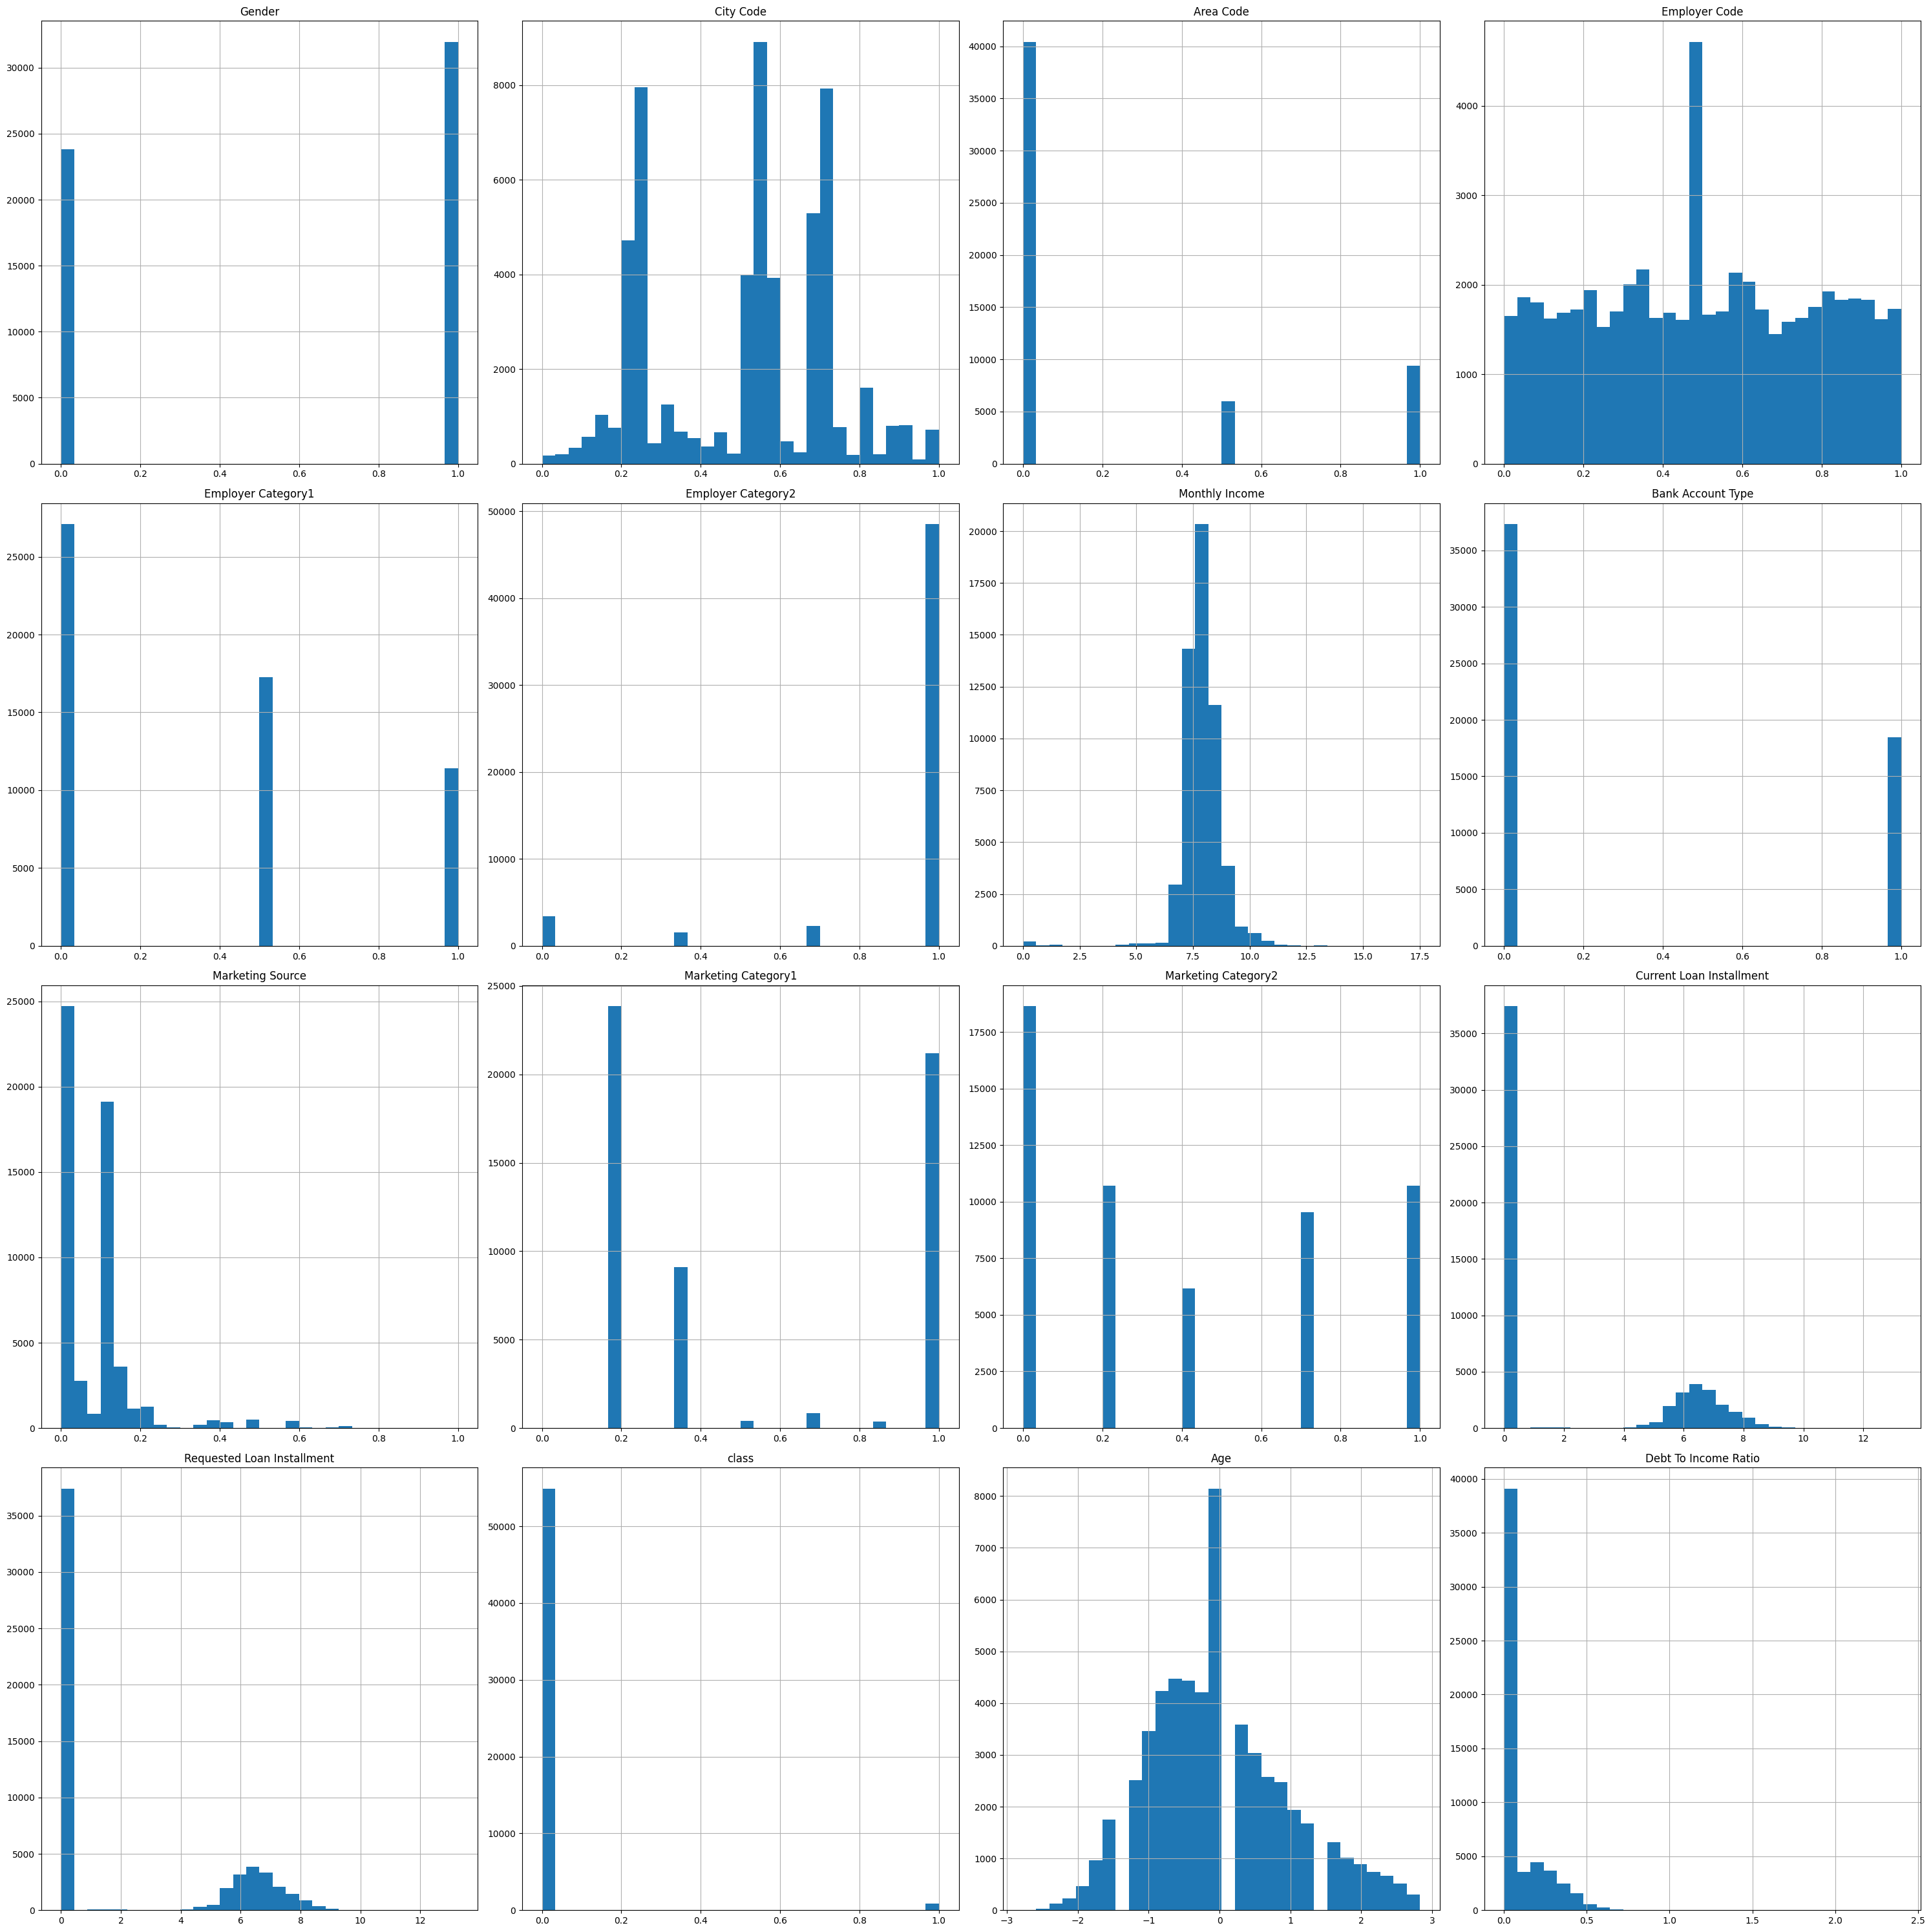

In [745]:
plot_histograms(df_train,df_train.columns)

In [746]:
# #plot numerical columns
# NUM_COLS = ['Monthly Income', 'Current Loan Installment', 'Requested Loan Amount', 'Loan Repayment Years', 'Interest Rate', 'Requested Loan Installment', 'Age', 'Debt To Income Ratio']
# plot_histograms(df_train,NUM_COLS)

In [747]:
# #plot Categorical columns
# CAT_COLS = ['Gender', 'City Code', 'Area Code', 'Employer Code', 'Employer Category1', 'Employer Category2', 'Bank Account Type', 'Marketing Source', 'Marketing Category1', 'Marketing Category2']
# plot_histograms(df_train,CAT_COLS)

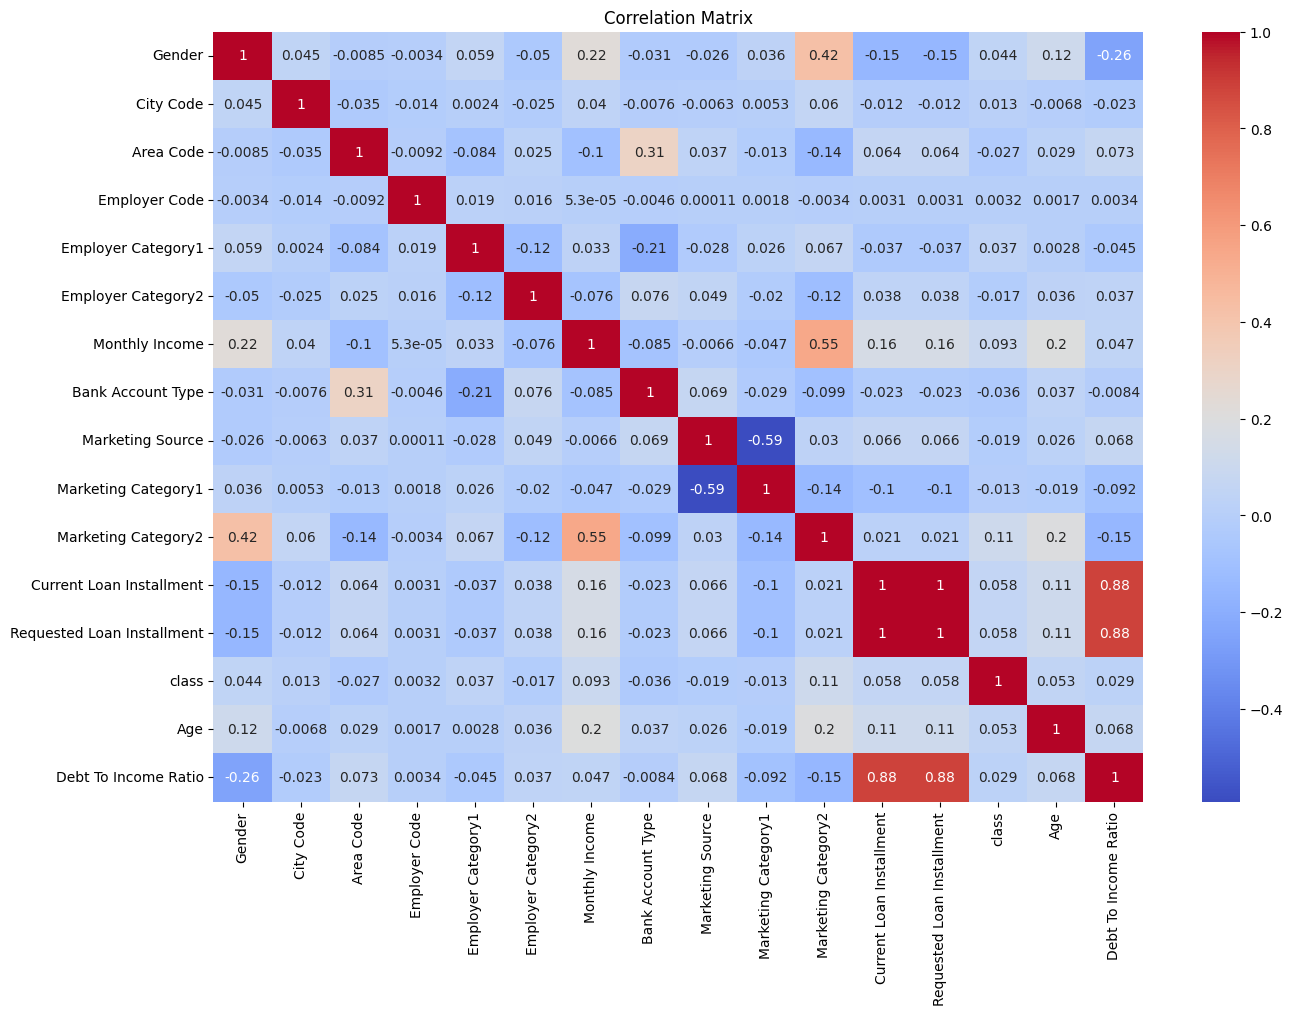

In [748]:
correlation_heatmap(df_train)

# Handle Imbalance Dataset

In [749]:
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

In [750]:
def prepare_data_rus_smote_mix(X:pd.DataFrame, y:pd.DataFrame, rus_sampling_strategy:str='auto', smote_sampling_strategy:str='auto', nm_sampling_strategy:str='auto', enable_rus:bool=False, enable_smote:bool=False, enable_nearmiss:bool=False, nm_version:int=3, test_size:float=0.2):
    """
    Prepare data for classification by balancing class distribution through a combination of Random Undersampling (RUS) and Synthetic Minority Oversampling Technique (SMOTE).

    Parameters:
    X (DataFrame): Feature columns of the dataset.
    y (Series): Target column of the dataset.
    rus_sampling_strategy (str): Sampling strategy for RandomUnderSampler. Default is 'auto'.
    smote_sampling_strategy (str): Sampling strategy for SMOTE. Default is 'auto'.
    enable_rus (bool): Flag to enable RandomUnderSampler. Default is True.
    enable_smote (bool): Flag to enable SMOTE. Default is True.
    test_size (float): Ratio of the dataset to include in the test split. Default is 0.2.

    Returns:
    X_train (DataFrame): Training set features.
    X_test (DataFrame): Testing set features.
    y_train (Series): Training set target.
    y_test (Series): Testing set target.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Undersample the majority class on Train dataset only
    if enable_rus:
        rus = RandomUnderSampler(random_state=42, sampling_strategy=rus_sampling_strategy)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    
    if enable_nearmiss:
        # Choose the version of NearMiss to use (NearMiss1, NearMiss2, NearMiss3)
        nm = NearMiss(version=nm_version, sampling_strategy=nm_sampling_strategy)
        X_train, y_train = nm.fit_resample(X_train, y_train)

    if enable_smote:
        smote = SMOTE(random_state=42, sampling_strategy=smote_sampling_strategy)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Print class distribution after resampling
    print('After resampling:')
    print('Train set:')
    print(y_train.value_counts())
    print('Test set:')
    print(y_test.value_counts())

    return X_train, X_test, y_train, y_test


# Data Leveling Processing & Test/Train Splitting

In [751]:
df_train['class'].value_counts()

class
0    54916
1      844
Name: count, dtype: int64

In [752]:
# Separate features and target variable
X = df_train.drop('class', axis=1)
y = df_train['class']

In [760]:
X_train, X_test, y_train, y_test = prepare_data_rus_smote_mix(X, y, rus_sampling_strategy=0.1, 
                                                              smote_sampling_strategy='auto',
                                                              nm_sampling_strategy='auto',
                                                              enable_rus=True,
                                                              enable_smote=True,
                                                              enable_nearmiss=False,
                                                              nm_version=3,
                                                              test_size=0.25)

After resampling:
Train set:
class
0    6330
1    6330
Name: count, dtype: int64
Test set:
class
0    13729
1      211
Name: count, dtype: int64


# DNN MODEL TRAINING (BASELINE)

In [761]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics

from keras.callbacks import EarlyStopping, ModelCheckpoint  

In [762]:
def build_train_dnn(X_train:pd.DataFrame, y_train:pd.DataFrame, X_test:pd.DataFrame, y_test:pd.DataFrame):
    """
    Builds a simple DNN model with 2 hidden layers and 1 output layer.
    32 neurons in layer 1, 16 neurons in layer 2, 1 neurons in output layer.
    Uses the adam optimizer and binary crossentropy loss function.
    Trains the model for 30 epochs and batch size of 32.
    
    Parameters:
        X_train: training set features
        X_test: testing set features
        y_train: training set target
        y_test: testing set target
    
    Returns:
        model: trained DNN model
        history: training history of the model
    """
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())

    my_metrics = [metrics.Accuracy(), metrics.Precision(), metrics.Recall()]

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=my_metrics)
    
    callback_a = ModelCheckpoint('./dnn/best_model.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=256, batch_size=32, verbose=1, callbacks=[callback_a, callback_b])
    # history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=0)

    return model, history

In [756]:
def plot_dnn_training(history) -> None:
    """
    Plots the training and validation accuracy of the DNN model over the epochs.
    
    Parameters:
        history: training history of the DNN model
    
    Returns:
        None
    """
    print(history.params)

    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('DNN Training')
    plt.legend(['training data', 'validation data'], loc='lower right')
    plt.show()

In [763]:
model, history = build_train_dnn(X_train, y_train, X_test, y_test)

Model: "sequential_13"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 32)                512       
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_40 (Dense)            (None, 16)                528       
                                                                 
 dropout_27 (Dropout)        (None, 16)                0         
                                                                 
 dense_41 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1057 (4.13 KB)
Trainable params: 1057 (4.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/256
368/396 [==================

/Users/ofotech_fitri/miniconda3/envs/tfdf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


381/396 [===========================>..] - ETA: 0s - loss: 0.6563 - accuracy: 0.0000e+00 - precision_10: 0.5961 - recall_10: 0.6470
Epoch 2: val_loss improved from 0.70568 to 0.62484, saving model to ./dnn/best_model.h5
396/396 [==============================] - 0s 928us/step - loss: 0.6555 - accuracy: 0.0000e+00 - precision_10: 0.5965 - recall_10: 0.6482 - val_loss: 0.6248 - val_accuracy: 0.0000e+00 - val_precision_10: 0.0296 - val_recall_10: 0.8152
Epoch 3/256
382/396 [===========================>..] - ETA: 0s - loss: 0.6181 - accuracy: 0.0000e+00 - precision_10: 0.6426 - recall_10: 0.7314
Epoch 3: val_loss improved from 0.62484 to 0.56352, saving model to ./dnn/best_model.h5
396/396 [==============================] - 0s 903us/step - loss: 0.6176 - accuracy: 0.0000e+00 - precision_10: 0.6438 - recall_10: 0.7313 - val_loss: 0.5635 - val_accuracy: 0.0000e+00 - val_precision_10: 0.0336 - val_recall_10: 0.8152
Epoch 4/256
388/396 [============================>.] - ETA: 0s - loss: 0.5967 

{'verbose': 1, 'epochs': 256, 'steps': 396}


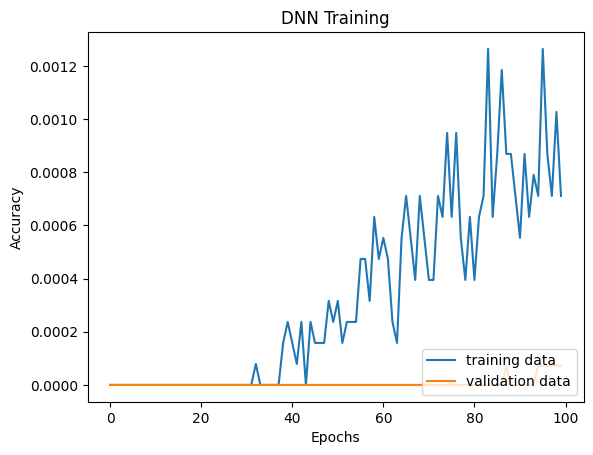

In [764]:
plot_dnn_training(history)

In [765]:
model.load_weights('./dnn/best_model.h5')

# MODEL EVALUATION

## Evaluate on Training Data

In [766]:
scores = model.evaluate(X_train, y_train)
print(model.metrics_names)
print(scores)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

396/396 [==============================] - 0s 370us/step - loss: 0.4275 - accuracy: 0.0000e+00 - precision_10: 0.7676 - recall_10: 0.8687 
['loss', 'accuracy', 'precision_10', 'recall_10']
[0.4275399446487427, 0.0, 0.7675879597663879, 0.8687203526496887]

accuracy: 0.00%


## Evaluate on Validation Data

In [767]:
scores = model.evaluate(X_test, y_test)
print(model.metrics_names)
print(scores)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

436/436 [==============================] - 0s 359us/step - loss: 0.3916 - accuracy: 0.0000e+00 - precision_10: 0.0404 - recall_10: 0.7393
['loss', 'accuracy', 'precision_10', 'recall_10']
[0.3916163742542267, 0.0, 0.04043545946478844, 0.7393364906311035]

accuracy: 0.00%


In [768]:
# Metrics for model evaluation
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, fbeta_score

In [769]:
def plot_confusion_matrix(y_test:pd.DataFrame, y_pred:pd.DataFrame, model_name:str='Model') -> None:
    """
    Plots the confusion matrix of the model.
    
    Parameters:
        y_test: testing set target
        y_pred: predicted target values
        model_name: name of the model
    
    Returns:
        None
    """
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name}: Confusion Matrix')
    plt.show()

In [666]:
def plot_roc_curve(y_test:pd.DataFrame, y_pred:pd.DataFrame, model_name:str='Model') -> None:
    """
    Plots the ROC curve of the model.
    
    Parameters:
        y_test: testing set target
        y_pred: predicted target values
        model_name: name of the model
    
    Returns:
        None
    """

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}: Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [667]:
def evaluate_dnn(model, X_test:pd.DataFrame, y_test:pd.DataFrame) -> None:
    """
    Evaluates the DNN model on the testing set.
    Produces classification report, accuracy score, confusion matrix and ROC curve.
    
    Parameters:
        model: trained DNN model
        X_test: testing set features
        y_test: testing set target
    
    Returns:
        None
    """

    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)

    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    print('Test Accuracy:', accuracy)

    print('Precsion Score:',precision_score(y_test, y_pred))
    print('Recall Score:', recall_score(y_test, y_pred))
    print('F Beta Score:', fbeta_score(y_test, y_pred, beta=0.5))

    plot_confusion_matrix(y_test, y_pred, model_name='DNN')
    plot_roc_curve(y_test, y_pred, model_name='DNN')

436/436 [==============================] - 0s 288us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     13729
           1       0.04      0.74      0.08       211

    accuracy                           0.73     13940
   macro avg       0.52      0.73      0.46     13940
weighted avg       0.98      0.73      0.83     13940

Test Accuracy: 0.7304878048780488
Precsion Score: 0.04043545878693624
Recall Score: 0.7393364928909952
F Beta Score: 0.04986255833280062


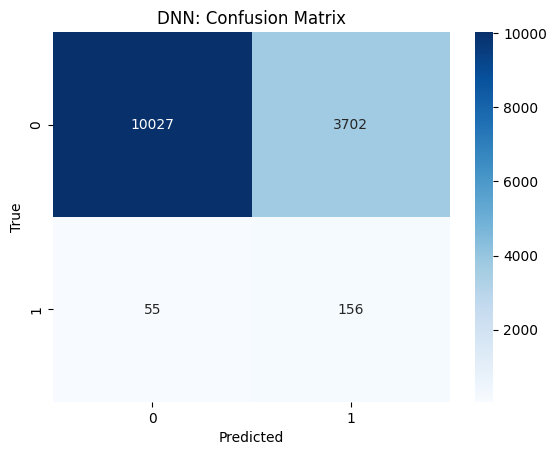

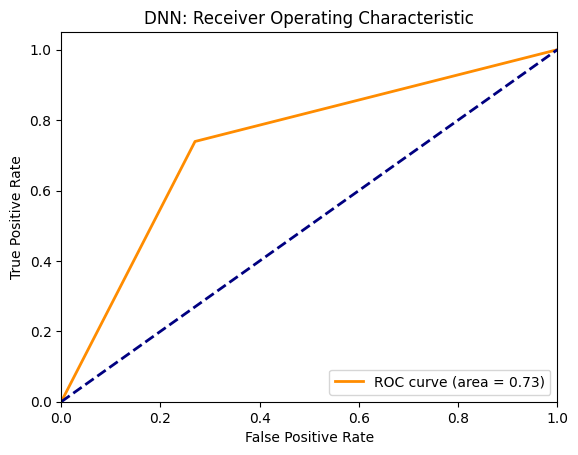

In [770]:
evaluate_dnn(model, X_test, y_test)

# SUBMISSION

In [771]:
df_test = data_preprocessing('../data/test.csv', is_submission=True)

Gender                           0
Date Of Birth                    7
Lead Creation Date               0
City Code                        0
Area Code                        0
Employer Code                    0
Employer Category1               0
Employer Category2               0
Monthly Income                   0
Bank Code                        0
Bank Account Type                0
Marketing Source                 0
Marketing Category1              0
Marketing Category2              0
Current Loan Installment        10
Requested Loan Amount         5574
Loan Repayment Years          5574
Interest Rate                 9488
Requested Loan Installment      10
dtype: int64
Gender                           0
Date Of Birth                    7
Lead Creation Date               0
City Code                        0
Area Code                        0
Employer Code                    0
Employer Category1               0
Employer Category2               0
Monthly Income                   0
Bank Co

In [670]:
desc_test = summary_df(df_test)
desc_test.style.background_gradient()

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
Gender,float64,13940,2,0.014347,0,0.000000,0.573458,0.494592,0.000000,0.000000,1.000000,1.000000,1.000000
City Code,float64,13940,485,3.479197,0,0.000000,0.504098,0.222097,0.000000,0.247636,0.534397,0.688980,1.000000
Area Code,float64,13940,3,0.021521,0,0.000000,0.218364,0.378677,0.000000,0.000000,0.000000,0.500000,1.000000
Employer Code,float64,13940,9602,68.880918,0,0.000000,0.498865,0.278032,0.000000,0.269750,0.499959,0.728793,1.000000
Employer Category1,float64,13940,3,0.021521,0,0.000000,0.355739,0.393641,0.000000,0.000000,0.500000,0.500000,1.000000
Employer Category2,float64,13940,4,0.028694,0,0.000000,0.908513,0.265182,0.000000,1.000000,1.000000,1.000000,1.000000
Monthly Income,float64,13940,1634,11.721664,0,0.000000,7.897122,0.913240,0.000000,7.463937,7.873217,8.343078,15.473739
Bank Account Type,float64,13940,2,0.014347,0,0.000000,0.356098,0.478862,0.000000,0.000000,0.000000,1.000000,1.000000
Marketing Source,float64,13940,25,0.179340,0,0.000000,0.074713,0.100023,0.000000,0.000000,0.071429,0.107143,1.000000
Marketing Category1,float64,13940,7,0.050215,0,0.000000,0.525813,0.384608,0.000000,0.166667,0.333333,1.000000,1.000000


In [671]:
def save_submission(model, df_test:pd.DataFrame, output_path:str):
    """
    Creates the predictions.csv file for submission to the kaggle competition.

    Parameters:
        model: trained classifier object

    Returns:
        predictions.csv: csv file of the predictions
    """
    

    # make predictions and append to the dataframe
    y_pred = model.predict(df_test)

    submit = pd.read_csv('../data/sample_submission.csv')
    submit['class'] = np.round(y_pred).astype(int)
    
    return submit.to_csv(output_path, index=False) 

In [772]:
BEST_MODEL = model
OUTPUT_PATH = '../submission/dnn/submission_01.csv'

save_submission(BEST_MODEL, df_test, OUTPUT_PATH)

436/436 [==============================] - 0s 282us/step


In [773]:
df_submit = pd.read_csv(OUTPUT_PATH)
df_submit['class'].value_counts()

class
0    10012
1     3928
Name: count, dtype: int64

# REMARKS:

1. Test and experiment more on various hyperparamters